# We can use undocumented API endpoints for getting data!

In [3]:
# But we need some info first
year = 2019
league_id = 83174673

# fetch league, get hardcoded cookies from browser
swid = '{9F7C3455-C43D-42A6-9D1A-AEB707CB5F0B}'
espn_s2 = 'AEAbG0EULx3Zj%2BBXRnR2huemCue3imODGQzS2bFsC6ldc6oK7WFCyVHIDa71t3AAsVCbaCAGI6AfRJv8Efy15OXnp3zMO5bMcfk%2F2ZFNhJ2Su3GMo2agzCWBVLfebZwx6afUlLoCNHndmRunHYkbcfHoZgz%2FNSZlep0G9UHXKXzazUs03JV5nSspxiymkMSFgdIvZjPrhxfQL5H4WH34S3iIrCgOUxyO%2BXQUxv3dtDzvgO3fxbdp3BPGhNBlDBPZk70U4sEttyWJXds5p2pDlhS7QYXRQYVwh6jpQy29%2FP6ZOQ%3D%3D'
cookies = {
    'espn_s2': espn_s2,
    'SWID': swid
}

In [1]:
# install api interface at https://github.com/cwendt94/ff-espn-api/
import requests

# helper function from ff-espn-api for api endpoints
def checkRequestStatus(status: int) -> None:
    if 500 <= status <= 503:
            raise Exception(status)
    if status == 401:
        raise Exception("Access Denied")

    elif status == 404:
        raise Exception("Invalid League")

    elif status != 200:
        raise Exception('Unknown %s Error' % status)


In [173]:
# example api query
ENDPOINT = "https://fantasy.espn.com/apis/v3/games/FFL/seasons/" + str(year) + "/segments/0/leagues/" + str(league_id)
params = ''

r = requests.get(ENDPOINT, params=params, cookies=cookies)
status = r.status_code
checkRequestStatus(status)
data = r.json()
print(data)

{'gameId': 1, 'id': 83174673, 'members': [{'displayName': 'YungFly', 'id': '{2A52739B-A4D2-440F-B78D-C1282294B36E}', 'isLeagueManager': False}, {'displayName': 'Ball, call, install', 'id': '{5E1655AA-B7E8-4112-8208-4024E2B806B4}', 'isLeagueManager': False}, {'displayName': 'espn57414091', 'id': '{86F13096-2F1D-44BC-B130-962F1DA4BCEA}', 'isLeagueManager': False}, {'displayName': 'typhe12', 'id': '{8BCE107A-C396-4216-A165-204DCBB7ACED}', 'isLeagueManager': False}, {'displayName': 'ESPNFAN6778113520', 'id': '{9DAF6913-3970-416F-BECB-D0DE77788ADB}', 'isLeagueManager': False}, {'displayName': 'shottysnipesonthepit', 'id': '{9F7C3455-C43D-42A6-9D1A-AEB707CB5F0B}', 'isLeagueManager': False}, {'displayName': 'JackMichaels55', 'id': '{AED6F6FD-B3C1-49EC-9329-C5E971023ED7}', 'isLeagueManager': False}, {'displayName': 'Lvl 69 Bloodelf', 'id': '{E8D2FE27-DB84-4C52-A39C-ACE7188E9114}', 'isLeagueManager': False}], 'scoringPeriodId': 14, 'seasonId': 2019, 'segmentId': 0, 'settings': {'name': 'Bromfie

In [182]:
# get team names
team_names = []
for t in range(1, 9):
    loc = data['teams'][t-1]['location']
    nm = data['teams'][t-1]['nickname']
    team_names.append('{} {}'.format(loc, nm))
print('Team names: {}'.format(team_names))

Team names: ['Big Greenie', 'il Bambino', ' . Draculas Army ', 'From da 🌬💰2 da Waller', 'Theilen  It', 'Get Kupp d', 'Persistent Panther', "Blount's Blunts"]


In [81]:
# fetch players, get scoring data for a given week
def get_scoring_period_data(scoringPeriodId):
    params = {
        'scoringPeriodId': scoringPeriodId
    }
    endpoint = 'https://fantasy.espn.com/apis/v3/games/ffl/seasons/' + str(year) + '/segments/0/leagues/' + str(league_id) + '?view=mMatchup&view=mMatchupScore'
    r = requests.get(endpoint, params=params, cookies=cookies)
    status = r.status_code
    checkRequestStatus(status)
    data = r.json()
    return data

In [82]:
# get player scoring data for all weeks
import pandas as pd
import numpy as np

# position codes
slotcodes = {
    0 : 'QB', 2 : 'RB', 4 : 'WR',
    6 : 'TE', 16: 'Def', 17: 'K',
    20: 'Bench', 21: 'IR', 23: 'Flex'
}

#week = 1
data = []

# iterate and grab data
for week in range(1, 14):
    
    d = get_scoring_period_data(week)
    
    for tm in d['teams']:
        tmid = tm['id']
        for p in tm['roster']['entries']:
            name = p['playerPoolEntry']['player']['fullName']
            slot = p['lineupSlotId']
            pos  = slotcodes[slot]

            # injured status (need try/exc bc of D/ST)
            inj = 'NA'
            try:
                inj = p['playerPoolEntry']['player']['injuryStatus']
            except:
                pass

            # projected/actual points
            proj, act = None, None
            for stat in p['playerPoolEntry']['player']['stats']:
                if stat['scoringPeriodId'] != week:
                    continue
                if stat['statSourceId'] == 0:
                    act = stat['appliedTotal']
                elif stat['statSourceId'] == 1:
                    proj = stat['appliedTotal']

            data.append([
                week, tmid, name, slot, pos, inj, proj, act
            ])
    print('Week {} Complete.'.format(week))

df = pd.DataFrame(data, 
                columns=['Week', 'Team', 'Player', 'Slot', 
                             'Pos', 'Status', 'Proj', 'Actual'])


Complete.


In [83]:
df

,Week,Team,Player,Slot,Pos,Status,Proj,Actual
0,1,1,Alvin Kamara,2,RB,ACTIVE,21.168970,23.9
1,1,1,Travis Kelce,6,TE,ACTIVE,16.695729,11.8
2,1,1,Antonio Brown,20,Bench,ACTIVE,0.000000,0.0
3,1,1,T.Y. Hilton,4,WR,QUESTIONABLE,12.778992,28.7
4,1,1,Brandin Cooks,4,WR,ACTIVE,14.444874,5.9
...,...,...,...,...,...,...,...,...
1554,13,8,DK Metcalf,20,Bench,ACTIVE,12.460458,11.5
1555,13,8,Younghoe Koo,17,K,ACTIVE,7.136907,7.0
1556,13,8,Ronald Jones II,2,RB,ACTIVE,13.140503,0.8
1557,13,8,Browns D/ST,16,Def,NA,5.676846,3.0


In [86]:
df.loc[df['Team'] == 4]

,Week,Team,Player,Slot,Pos,Status,Proj,Actual
45,1,4,DeAndre Hopkins,4,WR,ACTIVE,19.708130,31.10
46,1,4,Ezekiel Elliott,2,RB,ACTIVE,21.358942,13.30
47,1,4,Keenan Allen,4,WR,ACTIVE,15.935060,26.30
48,1,4,Dalvin Cook,2,RB,QUESTIONABLE,16.582898,26.00
49,1,4,Kenny Golladay,4,WR,ACTIVE,13.994064,14.20
...,...,...,...,...,...,...,...,...
1494,13,4,Dede Westbrook,20,Bench,ACTIVE,12.593848,19.00
1495,13,4,Josh Allen,20,Bench,ACTIVE,18.633559,23.54
1496,13,4,Alshon Jeffery,4,WR,ACTIVE,12.692082,28.70
1497,13,4,Sterling Shepard,20,Bench,ACTIVE,13.336015,13.00


In [108]:
# parse dataframe for team, week starters example
teamndx = 4
week = 13
bench_code = 20
arr = np.array(df['Team'] == teamndx) * np.array(df['Week'] == week) * np.array(df['Slot'] != bench_code)
df.loc[arr]

,Week,Team,Player,Slot,Pos,Status,Proj,Actual
1484,13,4,DeAndre Hopkins,4,WR,ACTIVE,16.239358,15.64
1485,13,4,Ezekiel Elliott,2,RB,ACTIVE,20.197528,20.70
1486,13,4,Keenan Allen,4,WR,ACTIVE,13.566087,18.80
1487,13,4,Dalvin Cook,23,Flex,QUESTIONABLE,21.186725,13.40
1489,13,4,Russell Wilson,0,QB,ACTIVE,20.631456,16.90
1490,13,4,Leonard Fournette,2,RB,ACTIVE,20.872706,18.10
1491,13,4,Darren Waller,6,TE,ACTIVE,12.495048,17.00
1493,13,4,Matt Gay,17,K,ACTIVE,8.551629,8.00
1496,13,4,Alshon Jeffery,4,WR,ACTIVE,12.692082,28.70
1498,13,4,Eagles D/ST,16,Def,NA,7.578931,-1.00


### There are a few ways of defining a "good" fantasy football player. one point of pride is when a manager consistently picks players that outperform their projected score. In other words, a manager picks players that perform better than they are expected to.

### The first question is, what is the relationship, among started players, between projected score and actual score?

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

# Some style formatting
sns.set_style('darkgrid')
plt.xkcd()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

C:\Users\rldun\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(19.125, 0.5, 'Actual score')

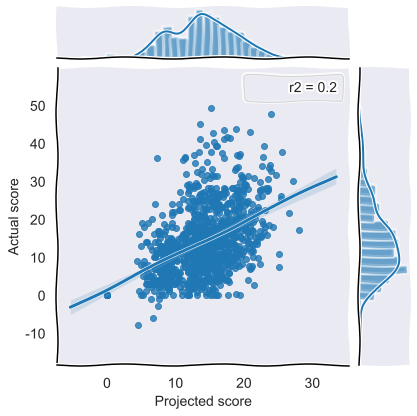

In [189]:
from scipy import stats

# grab only projected/actual of starters
arr = np.array(df['Slot'] != bench_code)
x = df.loc[arr]['Proj']
y = df.loc[arr]['Actual']

# function for fit
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# distribution/regression plot
#sns.jointplot(x, y, kind="reg")
sns.jointplot(x, y, kind="reg", stat_func=r2)

# decorate
plt.xlabel('Projected score')
plt.ylabel('Actual score')

### Given that projected/actual scores are reasonably matched, which teams consistently had good performance on actual - projected?


C:\Users\rldun\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\rldun\AppData\Local\Continuum\anaconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


([<matplotlib.axis.XTick at 0x23abc71b208>,
 <a list of 8 Text xticklabel objects>)

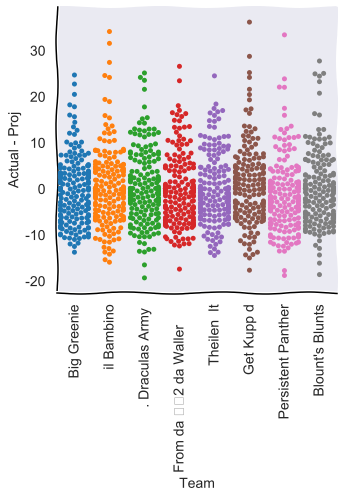

In [231]:
# add difference column to dataframe
df['Actual - Proj'] = df['Actual'] - df['Proj']

# try to do this all at once
sns.catplot(x="Team", y="Actual - Proj", data=df, kind='swarm');
locs, labels = plt.xticks()
plt.xticks(locs, team_names, rotation=90)

### But what about weekly scoring?

Text(0, 0.5, 'Total score')

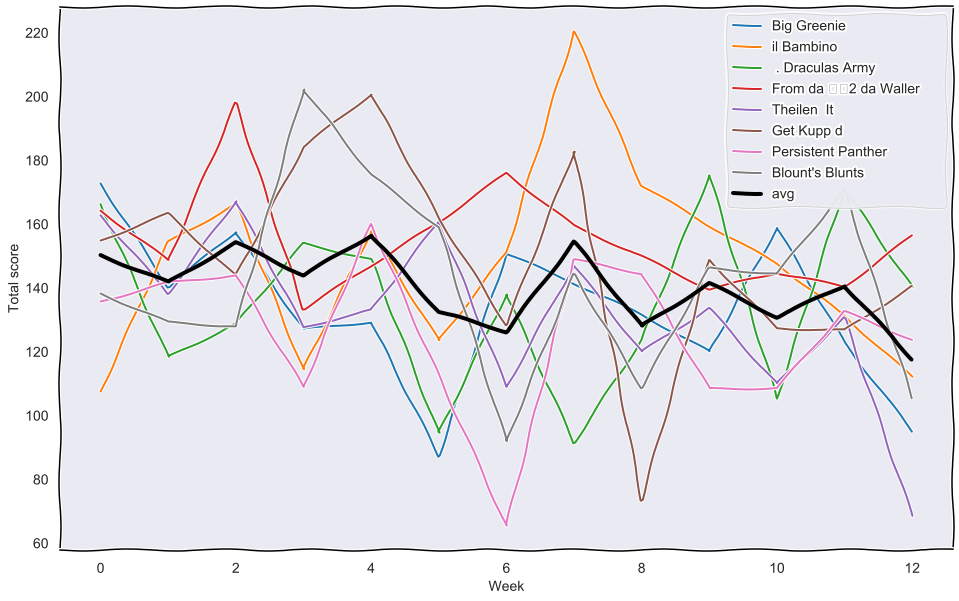

In [234]:
import copy

# grab team scoring data from every week
week_scores = np.zeros((8, 13))
for week in range(1, 14):
    for teamndx in range(1, 9):
        
        # select data and sum
        arr = np.array(df['Team'] == teamndx) * np.array(df['Week'] == week) * np.array(df['Slot'] != bench_code)
        week_scores[teamndx-1, week-1] = np.sum(df.loc[arr]['Actual'])
        
# plot and decorate
plt.figure(figsize=(16,10))
plt.plot(week_scores.T, lw=2)

# plot average
plt.plot(np.mean(week_scores, axis=0), 'k', lw=4)

# decorate
leg = copy.copy(team_names)
leg.append('avg')
plt.legend(leg)
plt.xlabel('Week')
plt.ylabel('Total score')


Text(0, 0.5, 'Mean-subtracted total score')

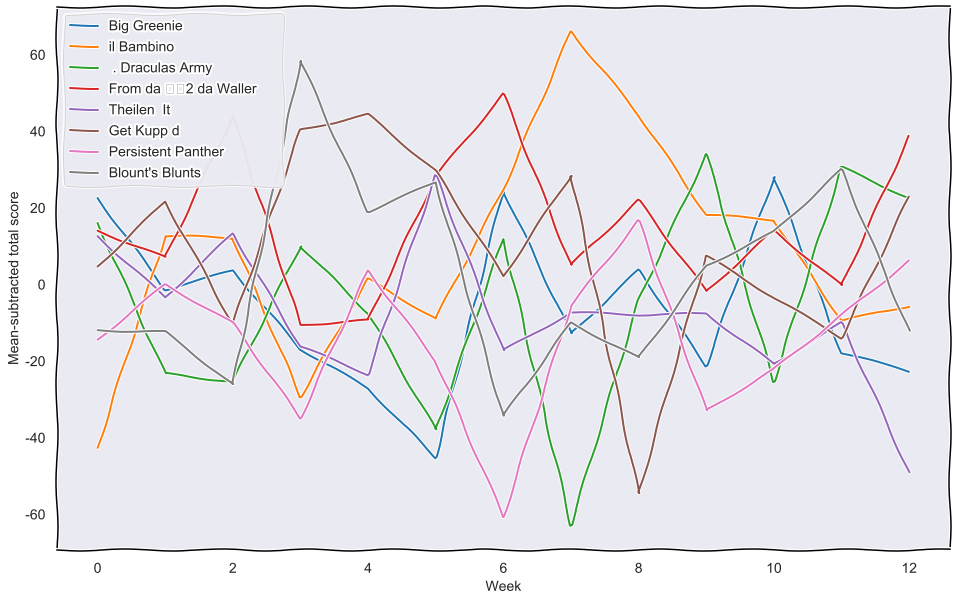

In [205]:
# plot and decorate
plt.figure(figsize=(16,10))

# plot average
avg = np.mean(week_scores, axis=0)
for t in range(0, 8):
    plt.plot(week_scores[t,:] - avg)

# decorate
leg = copy.copy(team_names)
leg.append('avg')
plt.legend(leg)
plt.xlabel('Week')
plt.ylabel('Mean-subtracted total score')

Text(0, 0.5, 'Total bench score')

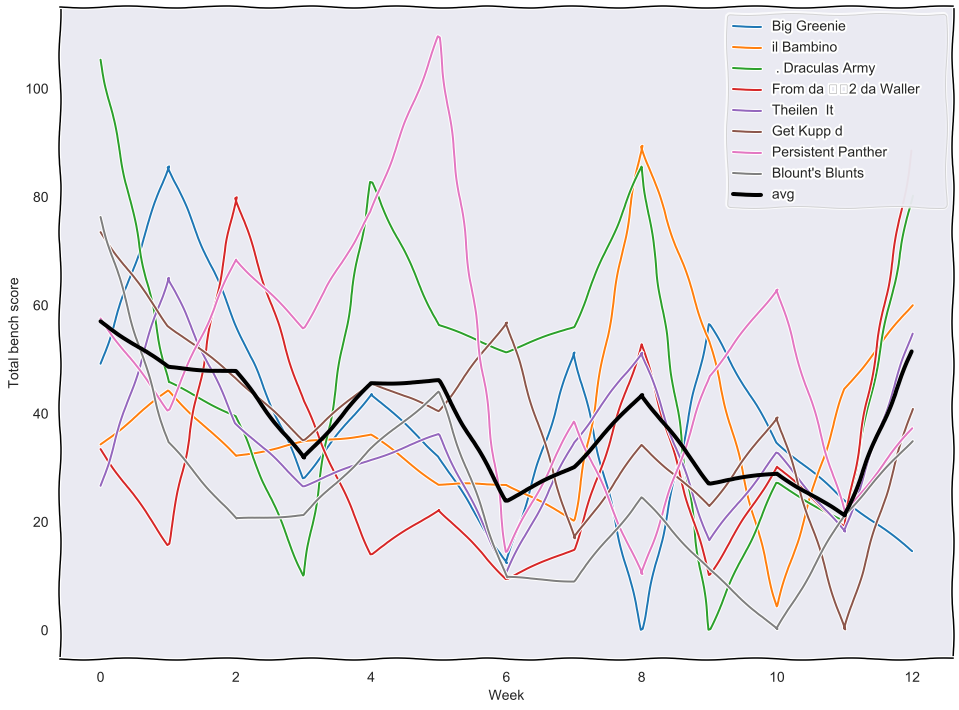

In [211]:
# bench scoring - who left the most points on the bench?
import copy

# grab team scoring data from every week
week_scores = np.zeros((8, 13))
for week in range(1, 14):
    for teamndx in range(1, 9):
        
        # select data and sum
        arr = np.array(df['Team'] == teamndx) * np.array(df['Week'] == week) * np.array(df['Slot'] == bench_code)
        week_scores[teamndx-1, week-1] = np.sum(df.loc[arr]['Actual'])
        
# plot and decorate
plt.figure(figsize=(16,12))
plt.plot(week_scores.T, lw=2)

# plot average
plt.plot(np.mean(week_scores, axis=0), 'k', lw=4)

# decorate
leg = copy.copy(team_names)
leg.append('avg')
plt.legend(leg, loc='upper right')
plt.xlabel('Week')
plt.ylabel('Total bench score')


Text(0, 0.5, 'Regular season points')

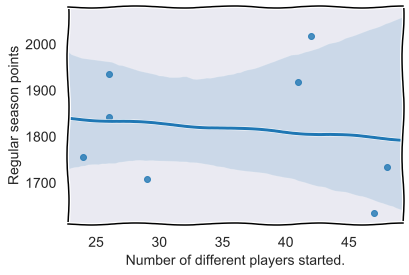

In [248]:
# get number of unique players a team started
uniq_players = []
for t in range(1, 9):
    
    arr = df.loc[df['Team'] == t]['Player']
    uniq_players.append(len(np.unique(arr)))
    
# grab team scoring data from every week
week_scores = np.zeros((8, 13))
for week in range(1, 14):
    for teamndx in range(1, 9):
        arr = np.array(df['Team'] == teamndx) * np.array(df['Week'] == week) * np.array(df['Slot'] != bench_code)
        week_scores[teamndx-1, week-1] = np.sum(df.loc[arr]['Actual'])
        
# regress number of players started and total points
x = uniq_players
y = np.sum(week_scores, axis=1)
sns.regplot(x=x, y=y)
plt.xlabel('Number of different players started.')
plt.ylabel('Regular season points')

# battle of the kickers!

Text(0, 0.5, 'RB score')

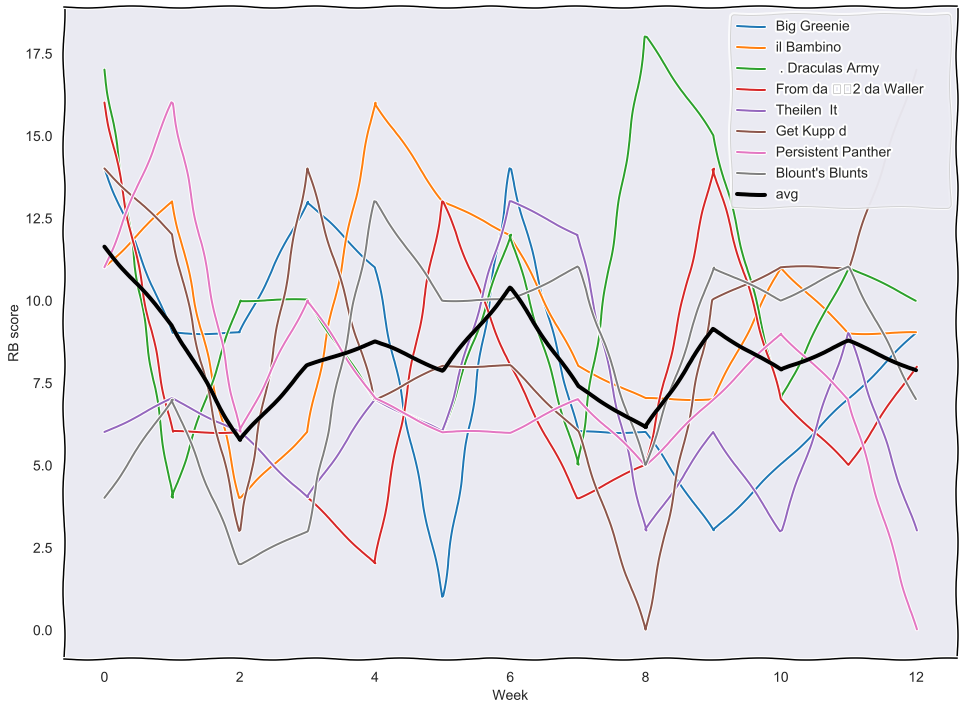

In [265]:
week_scores = np.zeros((8, 13))
for week in range(1, 14):
    for teamndx in range(1, 9):
        arr = np.array(df['Team'] == teamndx) * np.array(df['Week'] == week) * np.array(df['Slot'] != bench_code)
        tm_df = df.loc[arr]
        arr = np.array(tm_df['Pos'] == 'K')
        week_scores[teamndx-1, week-1] = np.sum(tm_df.loc[arr]['Actual'])

# plot
plt.figure(figsize=(16,12))
plt.plot(week_scores.T, lw=2)

# plot average
plt.plot(np.nanmean(week_scores, axis=0), 'k', lw=4)

# decorate
leg = copy.copy(team_names)
leg.append('avg')
plt.legend(leg, loc='upper right')
plt.xlabel('Week')
plt.ylabel('RB score')


In [257]:
## how often did a bench player outscore a starter?
## what if there was just one rb, one receiver, one qb, one te?

array([[14.,  9.,  9., 13., 11.,  1., 14.,  6.,  6.,  3.,  5.,  7.,  9.],
       [11., 13.,  4.,  6., 16., 13., 12.,  8.,  7.,  7., 11.,  9.,  9.],
       [17.,  4., 10., 10.,  7.,  6., 12.,  5., 18., 15.,  7., 11., 10.],
       [16.,  6.,  6.,  4.,  2., 13.,  8.,  4.,  5., 14.,  7.,  5.,  8.],
       [ 6.,  7.,  6.,  4.,  7.,  6., 13., 12.,  3.,  6.,  3.,  9.,  3.],
       [14., 12.,  3., 14.,  7.,  8.,  8.,  6., nan, 10., 11., 11., 17.],
       [11., 16.,  6., 10.,  7.,  6.,  6.,  7.,  5.,  7.,  9.,  7.,  0.],
       [ 4.,  7.,  2.,  3., 13., 10., 10., 11.,  5., 11., 10., 11.,  7.]])